# **Data Cleaning and Pre-processing**

In [1]:
import os
import pandas as pd
import numpy as np

def clean_csv_files(input_folder, output_folder, project_status_file):
    os.makedirs(output_folder, exist_ok=True)

    ps_df = pd.read_csv(project_status_file, keep_default_na=False, na_values=[], low_memory=False)

    columns_to_drop = [
        'issue_url', 'comment_url', 'id', 'issue_num',
        'title', 'user_login', 'user_id', 'user_name',
        'user_email', 'body', 'reactions'
    ]

    for filename in os.listdir(input_folder):
        if filename.endswith(".csv"):
            file_path = os.path.join(input_folder, filename)

            df = pd.read_csv(file_path, keep_default_na=False, na_values=[], low_memory=False)

            df = df.drop(columns=[col for col in columns_to_drop if col in df.columns], errors='ignore')

            # Convert created_at and updated_at to date format (YYYY-MM-DD) if they exist
            if 'created_at' in df.columns:
                df['created_at'] = pd.to_datetime(df['created_at'], errors='coerce').dt.date
            if 'updated_at' in df.columns:
                df['updated_at'] = pd.to_datetime(df['updated_at'], errors='coerce').dt.date

            # Compute the difference in days between updated_at and created_at, including the end date.
            if 'created_at' in df.columns and 'updated_at' in df.columns:
                df['days_elapsed'] = (df['updated_at'] - df['created_at']).apply(
                    lambda x: x.days + 1 if pd.notnull(x) else np.nan
                )

            # Replace blank or whitespace-only cells in all columns with np.nan
            df = df.replace(r'^\s*$', np.nan, regex=True)

            # For numeric columns, fill missing values with 0 and for non-numeric columns, leave the missing as np.nan.
            for col in df.columns:
                if pd.api.types.is_numeric_dtype(df[col]):
                    df[col] = df[col].fillna(0)
                else:
                    df[col] = df[col].fillna(np.nan)

            # Merge with project-status data:
            if 'repo_name' in df.columns:
                df = df.merge(ps_df[['project', 'status']], how='left', left_on='repo_name', right_on='project')
                # Drop the extra 'project' column coming from the merge
                df = df.drop(columns=['project'])

            # Save the cleaned DataFrame to a new CSV file
            output_file = os.path.join(output_folder, filename)
            df.to_csv(output_file, index=False)
            # print(f"Processed {filename} and saved to {output_file}")

input_folder = "issues-output"
output_folder = "issues-cleanedData"
project_status_file = "project-status.csv"
clean_csv_files(input_folder, output_folder, project_status_file)


## **EDA Analysis on the Issues Data**

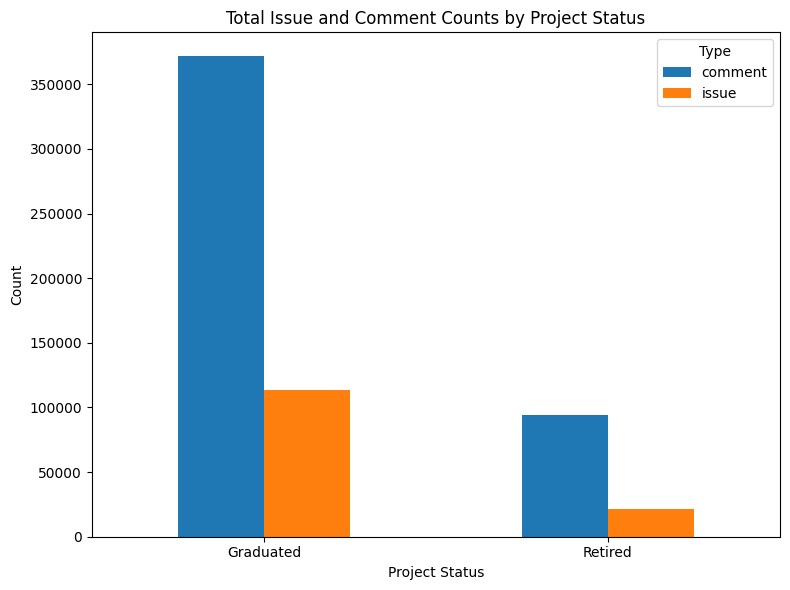

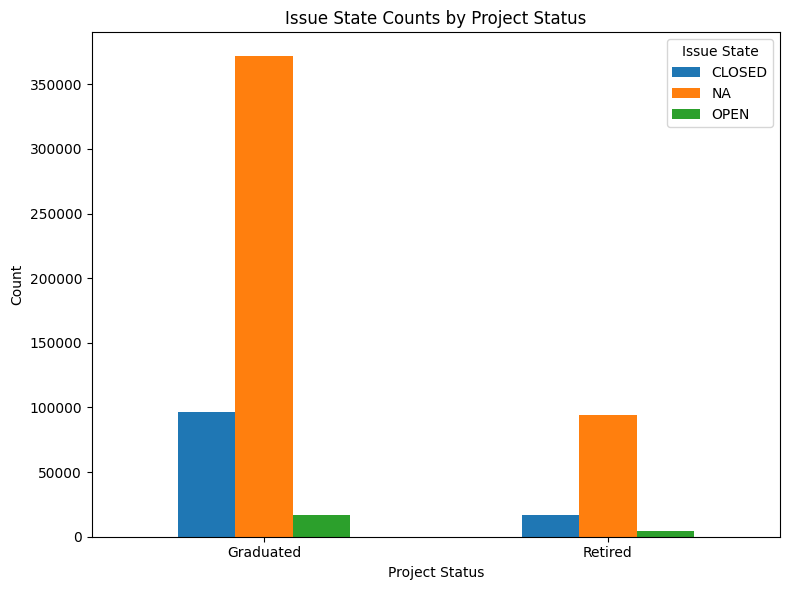

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def load_cleaned_data(folder):
    """Load all CSV files from the given folder and concatenate them into one DataFrame."""
    all_dfs = []
    for filename in os.listdir(folder):
        if filename.endswith(".csv"):
            file_path = os.path.join(folder, filename)
            df = pd.read_csv(file_path)
            all_dfs.append(df)
    if all_dfs:
        return pd.concat(all_dfs, ignore_index=True)
    else:
        return pd.DataFrame()

cleaned_folder = "issues-cleanedData"
df = load_cleaned_data(cleaned_folder)


# Plot 1: Count of Issues and Comments by Status

if "status" in df.columns and "type" in df.columns:
    # Group by status and type
    grouped_type = df.groupby(["status", "type"]).size().reset_index(name="count")
    pivot_type = grouped_type.pivot(index="status", columns="type", values="count").fillna(0)

    plt.figure(figsize=(8,6))
    pivot_type.plot(kind="bar", ax=plt.gca())
    plt.title("Total Issue and Comment Counts by Project Status")
    plt.xlabel("Project Status")
    plt.ylabel("Count")
    plt.xticks(rotation=0)
    plt.legend(title="Type")
    plt.tight_layout()
    plt.show()
else:
    print("Columns 'status' and/or 'type' not found in the data for Plot 1.")

# Plot 2: Issue State Counts (Open, Closed, NA) by Status

if "status" in df.columns and "issue_state" in df.columns:
    df["issue_state_group"] = df["issue_state"].fillna("NA")
    grouped_state = df.groupby(["status", "issue_state_group"]).size().reset_index(name="count")
    pivot_state = grouped_state.pivot(index="status", columns="issue_state_group", values="count").fillna(0)

    plt.figure(figsize=(8,6))
    pivot_state.plot(kind="bar", ax=plt.gca())
    plt.title("Issue State Counts by Project Status")
    plt.xlabel("Project Status")
    plt.ylabel("Count")
    plt.xticks(rotation=0)
    plt.legend(title="Issue State")
    plt.tight_layout()
    plt.show()
else:
    print("Columns 'status' and/or 'issue_state' not found in the data for Plot 2.")


# **LSTM Model for Classifying projects as Graduated/ Retired based on Issues Data**

In [ ]:
import os
import sys
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Masking
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# ---------------------------
# Hyperparameters
# ---------------------------
epochs = 10              # Number of epochs for training
batch_size = 16          # Batch size for training
learning_rate = 0.001    # Learning rate for Adam optimizer
weight_decay = 1e-4      # L2 regularization factor

# LSTM-specific hyperparameters:
lstm_units_layer1 = 128  # Units in first LSTM layer
lstm_units_layer2 = 64   # Units in second LSTM layer
dropout_rate = 0.02       # Dropout rate (and recurrent dropout) for LSTM layers

# ---------------------------
# Data Preparation
# ---------------------------
input_dir = "issues-cleanedData"  # Directory with cleaned CSV files

# Lists to hold each repository's sequence and label
sequences = []
labels = []

# Determine union of all categories for the 'issue_state' column across all files
issue_state_categories = set()
for filename in os.listdir(input_dir):
    if filename.endswith(".csv"):
        file_path = os.path.join(input_dir, filename)
        try:
            df = pd.read_csv(file_path)
        except Exception as e:
            print(f"Error reading {filename}: {e}")
            continue
        # Remove rows where 'type' equals "comment"
        if 'type' in df.columns:
            df = df[df['type'] != 'comment']
        if 'issue_state' in df.columns:
            unique_states = df['issue_state'].dropna().unique()
            issue_state_categories.update(unique_states)
issue_state_categories = sorted(list(issue_state_categories))

# Mapping for target labels: "graduated" is 1 and "retired" is 0
label_map = {"graduated": 1, "retired": 0}

# Process each CSV file (each representing one repository/sequence)
for filename in os.listdir(input_dir):
    if filename.endswith(".csv"):
        file_path = os.path.join(input_dir, filename)
        try:
            df = pd.read_csv(file_path)
        except Exception as e:
            print(f"Error reading {filename}: {e}")
            continue

        # Filter out rows where 'type' equals "comment"
        if 'type' in df.columns:
            df = df[df['type'] != 'comment']

        # Ensure the required columns exist
        if not all(col in df.columns for col in ['issue_state', 'days_elapsed', 'status']):
            print(f"Skipping {filename}: required columns missing.")
            continue

        # Use the first value in the 'status' column as the label (convert to lowercase)
        repo_status = df['status'].iloc[0]
        repo_status = repo_status.lower() if isinstance(repo_status, str) else repo_status
        if repo_status not in label_map:
            print(f"Skipping {filename}: status value '{repo_status}' not in label_map.")
            continue

        # One-hot encode 'issue_state' (convert to integers for consistency)
        issue_state_dummies = pd.get_dummies(df['issue_state']).astype(int)
        issue_state_dummies = issue_state_dummies.reindex(columns=issue_state_categories, fill_value=0)

        # Process the 'days_elapsed' column: convert to float and normalize (e.g., divide by 1000)
        try:
            days_elapsed = (df['days_elapsed'].astype(float).to_frame()) / 1000.0
        except Exception as e:
            print(f"Error processing 'days_elapsed' in {filename}: {e}")
            continue

        # If available, process an additional feature: 'comments_count'
        if 'comments_count' in df.columns:
            try:
                comments_count = (df['comments_count'].astype(float).to_frame()) / 100.0
            except Exception as e:
                print(f"Error processing 'comments_count' in {filename}: {e}")
                # If conversion fails, use a column of zeros
                comments_count = pd.DataFrame(np.zeros((df.shape[0], 1)), columns=["comments_count"])
            # Combine all features
            features = pd.concat([issue_state_dummies, days_elapsed, comments_count], axis=1)
        else:
            features = pd.concat([issue_state_dummies, days_elapsed], axis=1)

        # Fill any missing values in features
        features = features.fillna(0)

        # Convert the features DataFrame to a NumPy array (each row is a timestep)
        seq = features.values
        if seq.shape[0] == 0:
            print(f"Skipping {filename}: no valid rows after filtering.")
            continue

        sequences.append(seq)
        labels.append(label_map[repo_status])

# Ensure we have at least one valid sequence
if not sequences:
    sys.exit("Error: No valid sequences found. Check CSV files for required columns and valid status values.")

# ---------------------------
# Sequence Padding
# ---------------------------
# Pad sequences so that they all have the same number of timesteps.
# A pad value of -999 is used (chosen to be unlikely to appear in the actual features)
max_timesteps = max(seq.shape[0] for seq in sequences)
X = pad_sequences(sequences, maxlen=max_timesteps, dtype='float32', padding='post', value=-999.0)
y = np.array(labels)

# Print summary of processed data
print("Processed Data Summary:")
print("Number of sequences:", len(sequences))
print("Shape of padded sequences (X):", X.shape)
print("Labels (y):", y)

# ---------------------------
# Train / Validation / Test Split (70/10/20)
# ---------------------------
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=42, shuffle=True
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=2/3, stratify=y_temp, random_state=42, shuffle=True
)

print("Train shape:", X_train.shape, y_train.shape)
print("Validation shape:", X_val.shape, y_val.shape)
print("Test shape:", X_test.shape, y_test.shape)

# ---------------------------
# Build the LSTM Model
# ---------------------------
num_features = X.shape[2]  # Number of features per timestep

model = Sequential()
# Add a Masking layer so that padded timesteps (value = -999) are ignored
model.add(Masking(mask_value=-999.0, input_shape=(max_timesteps, num_features)))

# First LSTM layer with 128 units, dropout and recurrent dropout, returning sequences (for stacking)
model.add(LSTM(lstm_units_layer1,
               dropout=dropout_rate,
               return_sequences=True,
               kernel_regularizer=l2(weight_decay)))

# Second LSTM layer with 64 units, dropout and recurrent dropout (outputs final hidden state)
model.add(LSTM(lstm_units_layer2,
               dropout=dropout_rate,
               kernel_regularizer=l2(weight_decay)))

# Final Dense layer for binary classification (graduated vs. retired)
model.add(Dense(1, activation='relu', kernel_regularizer=l2(weight_decay)))

# Compile the model using Adam optimizer
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

# ---------------------------
# Train the Model
# ---------------------------
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val))

# ---------------------------
# Evaluate on Test Set and Print Confusion Matrix
# ---------------------------
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int).reshape(-1)

cm = confusion_matrix(y_test, y_pred)
cr = classification_report(y_test, y_pred)

print("Confusion Matrix:")
print(cm)
print("\nClassification Report:")
print(cr)


Processed Data Summary:
Number of sequences: 88
Shape of padded sequences (X): (88, 15520, 3)
Labels (y): [1 0 1 1 1 0 1 1 1 1 1 1 0 1 1 0 1 0 0 0 1 1 1 1 1 0 0 1 1 1 1 1 0 0 0 1 1
 1 1 0 1 1 0 1 1 1 0 1 1 1 0 1 0 1 1 1 1 0 1 1 0 1 0 0 1 1 0 0 1 1 1 0 0 1
 1 1 0 0 1 0 0 0 1 1 1 1 1 1]
Train shape: (61, 15520, 3) (61,)
Validation shape: (9, 15520, 3) (9,)
Test shape: (18, 15520, 3) (18,)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ masking (Masking)                    │ (None, 15520, 3)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 15520, 128)          │          67,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 117,057 (457.25 KB)

 Trainable params: 117,057 (457.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 234s 57s/step - accuracy: 0.3338 - loss: 1.8223 - val_accuracy: 0.7778 - val_loss: 0.5312
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 251s 54s/step - accuracy: 0.6290 - loss: 0.7248 - val_accuracy: 0.7778 - val_loss: 0.5625
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 217s 54s/step - accuracy: 0.5617 - loss: 0.7581 - val_accuracy: 0.7778 - val_loss: 0.6396
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 274s 58s/step - accuracy: 0.5787 - loss: 0.7156 - val_accuracy: 0.7778 - val_loss: 0.6200
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 252s 56s/step - accuracy: 0.6203 - loss: 0.6736 - val_accuracy: 0.7778 - val_loss: 0.5858
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 261s 55s/step - accuracy: 0.6647 - loss: 0.6270 - val_accuracy: 0.7778 - val_loss: 0.5729
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 219s 55s/step - accuracy: 0.6477 - loss: 0.6630 - val_accuracy: 0.7778 - val_loss: 0.5773
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 218s 54s/step - accuracy: 0.6668 - loss: 0.6281 - val_accuracy: 0.7778 - val_loss:

In [ ]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.8/231.8 kB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 6.7 MB/s eta 0:00:00


[I 2025-03-07 05:02:23,865] A new study created in memory with name: no-name-d9e4ec05-cbd8-4fc9-815e-ebdb26496939


Processed Data Summary:
Number of sequences: 88
Shape of padded sequences (X): (88, 27260, 3)
Labels (y): [1 1 1 1 0 0 1 1 1 1 0 0 1 1 1 1 1 0 0 1 1 1 0 1 0 1 0 1 0 1 1 1 0 1 1 1 0
 1 0 1 0 0 1 1 1 0 0 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 0 1 1 1 0 0 1 0 0 1 1 0
 0 0 1 1 1 0 1 1 0 1 0 1 1 1]


  0%|          | 0/10 [00:00<?, ?it/s]

<ipython-input-3-1d8b81e3c383>:134: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
<ipython-input-3-1d8b81e3c383>:135: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dr = trial.suggest_uniform("dropout_rate", 0.1, 0.5)
<ipython-input-3-1d8b81e3c383>:137: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  wd = trial.suggest_loguniform("weight_decay", 1e-5, 1e-3)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 63s 12s/step - accuracy: 0.3773 - loss: 1.3653 - val_accuracy: 0.3333 - val_loss: 1.3565
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 80s 13s/step - accuracy: 0.3773 - loss: 1.1821 - val_accuracy: 0.3333 - val_loss: 1.3520
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 83s 13s/step - accuracy: 0.3773 - loss: 1.4567 - val_accuracy: 0.3333 - val_loss: 1.3477
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 80s 13s/step - accuracy: 0.3773 - loss: 1.2491 - val_accuracy: 0.3333 - val_loss: 1.3436
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 81s 12s/step - accuracy: 0.3773 - loss: 1.4182 - val_accuracy: 0.3333 - val_loss: 1.3397
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 82s 12s/step - accuracy: 0.3773 - loss: 1.5568 - val_accuracy: 0.3333 - val_loss: 1.3358
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 85s 13s/step - accuracy: 0.3773 - loss: 1.2784 - val_accuracy: 0.3333 - val_loss: 1.3320
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 78s 12s/step - accuracy: 0.3773 - loss: 1.1967 - val_accuracy: 0.3333 - val_loss: 1.3284


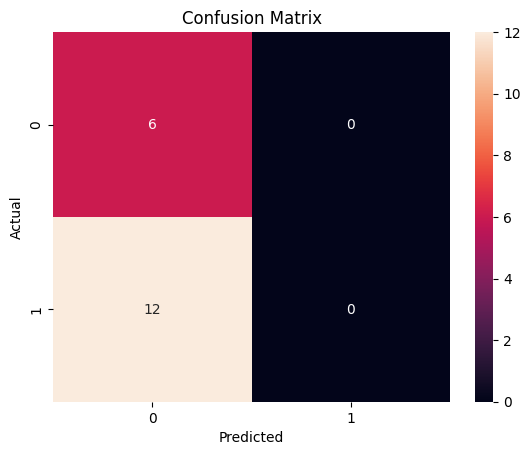

[I 2025-03-07 05:15:08,916] Trial 0 finished with value: 1.3212838172912598 and parameters: {'learning_rate': 2.0112923027457703e-05, 'dropout_rate': 0.13632152694934746, 'batch_size': 16, 'weight_decay': 0.0007708288394819343, 'lstm_units': 32}. Best is trial 0 with value: 1.3212838172912598.
Epoch 1/10


<ipython-input-3-1d8b81e3c383>:134: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
<ipython-input-3-1d8b81e3c383>:135: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dr = trial.suggest_uniform("dropout_rate", 0.1, 0.5)
<ipython-input-3-1d8b81e3c383>:137: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  wd = trial.suggest_loguniform("weight_decay", 1e-5, 1e-3)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/

1/1 ━━━━━━━━━━━━━━━━━━━━ 24s 24s/step - accuracy: 0.3443 - loss: 7.6774 - val_accuracy: 0.3333 - val_loss: 10.7457
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 38s 38s/step - accuracy: 0.3443 - loss: 6.3187 - val_accuracy: 0.3333 - val_loss: 10.7457
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step - accuracy: 0.3443 - loss: 6.8625 - val_accuracy: 0.3333 - val_loss: 10.7457
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step - accuracy: 0.3443 - loss: 6.4558 - val_accuracy: 0.3333 - val_loss: 10.7457
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 22s 22s/step - accuracy: 0.3443 - loss: 5.8776 - val_accuracy: 0.3333 - val_loss: 10.7457
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step - accuracy: 0.3443 - loss: 6.7275 - val_accuracy: 0.3333 - val_loss: 10.7457
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 21s 21s/step - accuracy: 0.3443 - loss: 6.4293 - val_accuracy: 0.3333 - val_loss: 10.7457
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step - accuracy: 0.3443 - loss: 6.1096 - val_accuracy: 0.3333 - val_loss: 10.7457
Epo

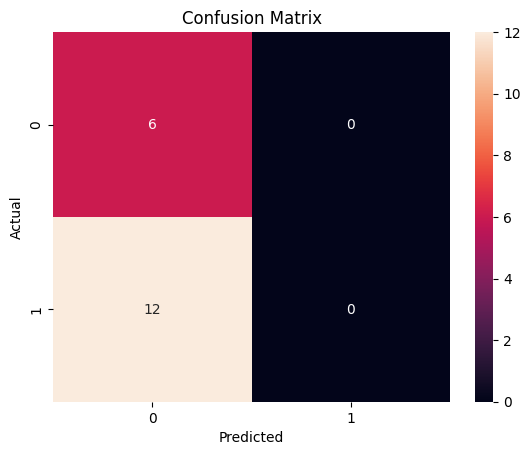

[I 2025-03-07 05:18:57,514] Trial 1 finished with value: 10.745678901672363 and parameters: {'learning_rate': 6.745843996037322e-05, 'dropout_rate': 0.3273496061565938, 'batch_size': 64, 'weight_decay': 3.8839047566371e-05, 'lstm_units': 32}. Best is trial 0 with value: 1.3212838172912598.
Epoch 1/10


<ipython-input-3-1d8b81e3c383>:134: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
<ipython-input-3-1d8b81e3c383>:135: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dr = trial.suggest_uniform("dropout_rate", 0.1, 0.5)
<ipython-input-3-1d8b81e3c383>:137: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  wd = trial.suggest_loguniform("weight_decay", 1e-5, 1e-3)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/

1/1 ━━━━━━━━━━━━━━━━━━━━ 27s 27s/step - accuracy: 0.3443 - loss: 3.8819 - val_accuracy: 0.3333 - val_loss: 1.4495
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 23s 23s/step - accuracy: 0.3443 - loss: 1.3680 - val_accuracy: 0.3333 - val_loss: 1.1994
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 39s 39s/step - accuracy: 0.3934 - loss: 1.1615 - val_accuracy: 0.3333 - val_loss: 1.0214
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 27s 27s/step - accuracy: 0.4098 - loss: 1.4694 - val_accuracy: 0.3333 - val_loss: 0.8767
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 35s 35s/step - accuracy: 0.5574 - loss: 1.4180 - val_accuracy: 0.3333 - val_loss: 0.7570
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 42s 42s/step - accuracy: 0.5738 - loss: 1.3297 - val_accuracy: 0.6667 - val_loss: 0.6528
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 21s 21s/step - accuracy: 0.5902 - loss: 1.7862 - val_accuracy: 0.7778 - val_loss: 0.6034
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 42s 42s/step - accuracy: 0.5410 - loss: 2.3254 - val_accuracy: 0.6667 - val_loss: 0.5778
Epoch 9/10


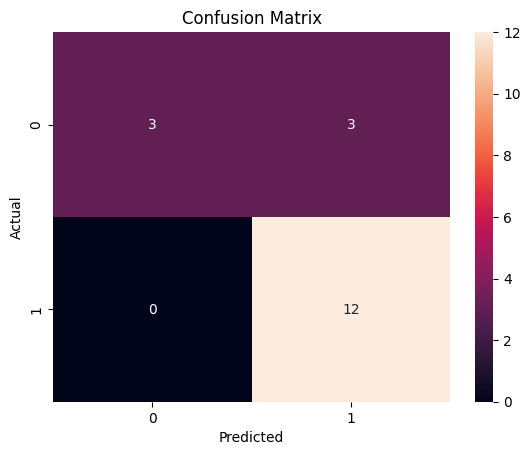

[I 2025-03-07 05:24:23,351] Trial 2 finished with value: 0.7450165152549744 and parameters: {'learning_rate': 0.0015722873806834551, 'dropout_rate': 0.3937392288078445, 'batch_size': 64, 'weight_decay': 0.00047822792484812334, 'lstm_units': 64}. Best is trial 2 with value: 0.7450165152549744.
Epoch 1/10


<ipython-input-3-1d8b81e3c383>:134: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
<ipython-input-3-1d8b81e3c383>:135: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dr = trial.suggest_uniform("dropout_rate", 0.1, 0.5)
<ipython-input-3-1d8b81e3c383>:137: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  wd = trial.suggest_loguniform("weight_decay", 1e-5, 1e-3)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/

1/1 ━━━━━━━━━━━━━━━━━━━━ 29s 29s/step - accuracy: 0.3443 - loss: 3.5486 - val_accuracy: 0.3333 - val_loss: 1.7480
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 26s 26s/step - accuracy: 0.3443 - loss: 2.4624 - val_accuracy: 0.3333 - val_loss: 1.7417
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 21s 21s/step - accuracy: 0.3443 - loss: 2.5427 - val_accuracy: 0.3333 - val_loss: 1.7353
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 42s 42s/step - accuracy: 0.3443 - loss: 2.5243 - val_accuracy: 0.3333 - val_loss: 1.7288
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 41s 41s/step - accuracy: 0.3443 - loss: 2.0895 - val_accuracy: 0.3333 - val_loss: 1.7225
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 23s 23s/step - accuracy: 0.3443 - loss: 2.1507 - val_accuracy: 0.3333 - val_loss: 1.7163
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 40s 40s/step - accuracy: 0.3443 - loss: 1.8968 - val_accuracy: 0.3333 - val_loss: 1.7104
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 40s 40s/step - accuracy: 0.3443 - loss: 2.2581 - val_accuracy: 0.3333 - val_loss: 1.7046
Epoch 9/10


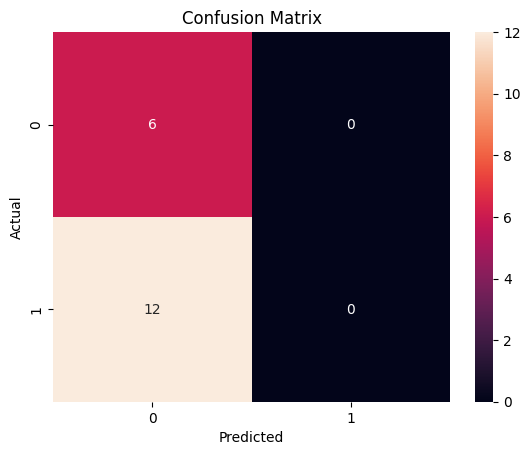

[I 2025-03-07 05:29:54,053] Trial 3 finished with value: 1.69346022605896 and parameters: {'learning_rate': 2.578356877714588e-05, 'dropout_rate': 0.4317849662763906, 'batch_size': 64, 'weight_decay': 0.00010714593625036118, 'lstm_units': 64}. Best is trial 2 with value: 0.7450165152549744.
Epoch 1/10


<ipython-input-3-1d8b81e3c383>:134: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
<ipython-input-3-1d8b81e3c383>:135: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dr = trial.suggest_uniform("dropout_rate", 0.1, 0.5)
<ipython-input-3-1d8b81e3c383>:137: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  wd = trial.suggest_loguniform("weight_decay", 1e-5, 1e-3)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/

2/2 ━━━━━━━━━━━━━━━━━━━━ 38s 19s/step - accuracy: 0.3441 - loss: 6.8530 - val_accuracy: 0.3333 - val_loss: 10.7458
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 44s 20s/step - accuracy: 0.3441 - loss: 4.6751 - val_accuracy: 0.3333 - val_loss: 10.7458
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 72s 18s/step - accuracy: 0.3441 - loss: 6.0896 - val_accuracy: 0.3333 - val_loss: 10.7458
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 41s 18s/step - accuracy: 0.3441 - loss: 5.6938 - val_accuracy: 0.3333 - val_loss: 10.7458
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 41s 17s/step - accuracy: 0.3441 - loss: 4.9372 - val_accuracy: 0.3333 - val_loss: 10.7458
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 35s 20s/step - accuracy: 0.3441 - loss: 5.0542 - val_accuracy: 0.3333 - val_loss: 10.7458
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 34s 17s/step - accuracy: 0.3441 - loss: 5.0259 - val_accuracy: 0.3333 - val_loss: 10.7458
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 42s 20s/step - accuracy: 0.3441 - loss: 6.2107 - val_accuracy: 0.3333 - val_loss: 10.7458
Epo

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Test Accuracy: 0.3333333333333333


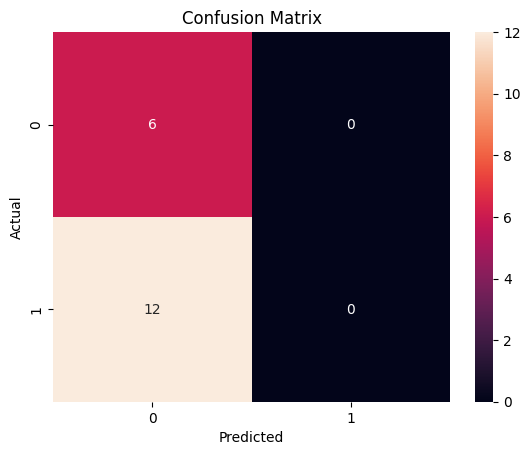

[I 2025-03-07 05:37:13,823] Trial 4 finished with value: 10.74577808380127 and parameters: {'learning_rate': 0.00014123210288044218, 'dropout_rate': 0.4792551968596118, 'batch_size': 32, 'weight_decay': 4.573490197239634e-05, 'lstm_units': 64}. Best is trial 2 with value: 0.7450165152549744.
Epoch 1/10


<ipython-input-3-1d8b81e3c383>:134: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
<ipython-input-3-1d8b81e3c383>:135: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dr = trial.suggest_uniform("dropout_rate", 0.1, 0.5)
<ipython-input-3-1d8b81e3c383>:137: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  wd = trial.suggest_loguniform("weight_decay", 1e-5, 1e-3)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/

1/1 ━━━━━━━━━━━━━━━━━━━━ 30s 30s/step - accuracy: 0.3443 - loss: 4.3992 - val_accuracy: 0.3333 - val_loss: 2.3894
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 37s 37s/step - accuracy: 0.3443 - loss: 2.3822 - val_accuracy: 0.3333 - val_loss: 2.0214
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 41s 41s/step - accuracy: 0.3443 - loss: 1.8879 - val_accuracy: 0.3333 - val_loss: 1.8209
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 24s 24s/step - accuracy: 0.3443 - loss: 1.5722 - val_accuracy: 0.3333 - val_loss: 1.6857
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 21s 21s/step - accuracy: 0.3443 - loss: 1.3627 - val_accuracy: 0.3333 - val_loss: 1.5814
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 22s 22s/step - accuracy: 0.3443 - loss: 1.3721 - val_accuracy: 0.3333 - val_loss: 1.5000
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 40s 40s/step - accuracy: 0.3443 - loss: 1.3811 - val_accuracy: 0.3333 - val_loss: 1.4336
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 25s 25s/step - accuracy: 0.3443 - loss: 1.2913 - val_accuracy: 0.3333 - val_loss: 1.3778
Epoch 9/10


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Test Accuracy: 0.3333333333333333


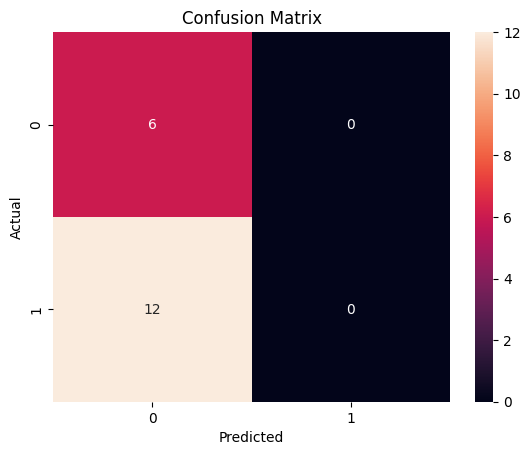

[I 2025-03-07 05:42:20,618] Trial 5 finished with value: 1.2878901958465576 and parameters: {'learning_rate': 0.0009265306936639451, 'dropout_rate': 0.19176603564747394, 'batch_size': 64, 'weight_decay': 0.00012528028760471627, 'lstm_units': 64}. Best is trial 2 with value: 0.7450165152549744.
Epoch 1/10


<ipython-input-3-1d8b81e3c383>:134: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
<ipython-input-3-1d8b81e3c383>:135: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dr = trial.suggest_uniform("dropout_rate", 0.1, 0.5)
<ipython-input-3-1d8b81e3c383>:137: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  wd = trial.suggest_loguniform("weight_decay", 1e-5, 1e-3)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/

2/2 ━━━━━━━━━━━━━━━━━━━━ 32s 15s/step - accuracy: 0.3441 - loss: 6.9167 - val_accuracy: 0.3333 - val_loss: 10.7461
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 41s 15s/step - accuracy: 0.3441 - loss: 6.3763 - val_accuracy: 0.3333 - val_loss: 10.7461
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 40s 15s/step - accuracy: 0.3441 - loss: 6.6404 - val_accuracy: 0.3333 - val_loss: 10.7461
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 42s 15s/step - accuracy: 0.3441 - loss: 6.8895 - val_accuracy: 0.3333 - val_loss: 10.7461
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 28s 15s/step - accuracy: 0.3441 - loss: 6.1203 - val_accuracy: 0.3333 - val_loss: 10.7461
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 40s 15s/step - accuracy: 0.3441 - loss: 6.0656 - val_accuracy: 0.3333 - val_loss: 10.7461
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 29s 17s/step - accuracy: 0.3441 - loss: 5.9381 - val_accuracy: 0.3333 - val_loss: 10.7461
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 39s 15s/step - accuracy: 0.3441 - loss: 6.0441 - val_accuracy: 0.3333 - val_loss: 10.7461
Epo

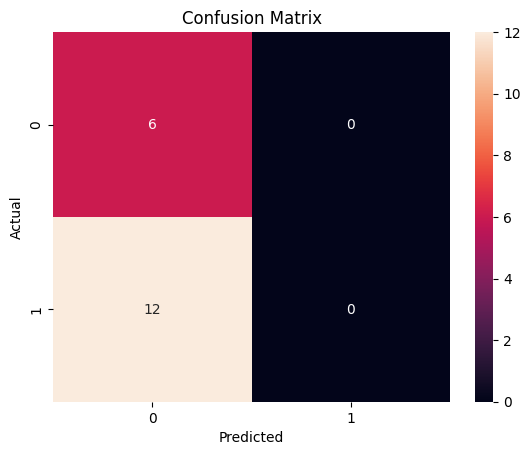

[I 2025-03-07 05:48:22,852] Trial 6 finished with value: 10.746123313903809 and parameters: {'learning_rate': 1.893562137149962e-05, 'dropout_rate': 0.3060794846176752, 'batch_size': 32, 'weight_decay': 8.724883318874547e-05, 'lstm_units': 32}. Best is trial 2 with value: 0.7450165152549744.
Epoch 1/10


<ipython-input-3-1d8b81e3c383>:134: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
<ipython-input-3-1d8b81e3c383>:135: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dr = trial.suggest_uniform("dropout_rate", 0.1, 0.5)
<ipython-input-3-1d8b81e3c383>:137: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  wd = trial.suggest_loguniform("weight_decay", 1e-5, 1e-3)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/

2/2 ━━━━━━━━━━━━━━━━━━━━ 31s 15s/step - accuracy: 0.3441 - loss: 6.5296 - val_accuracy: 0.3333 - val_loss: 10.7491
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 41s 14s/step - accuracy: 0.3441 - loss: 4.9532 - val_accuracy: 0.3333 - val_loss: 10.7491
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 27s 15s/step - accuracy: 0.3441 - loss: 4.9932 - val_accuracy: 0.3333 - val_loss: 10.7491
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 41s 15s/step - accuracy: 0.3441 - loss: 5.3866 - val_accuracy: 0.3333 - val_loss: 10.7491
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 27s 14s/step - accuracy: 0.3441 - loss: 4.7697 - val_accuracy: 0.3333 - val_loss: 10.7491
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 42s 15s/step - accuracy: 0.3441 - loss: 5.0927 - val_accuracy: 0.3333 - val_loss: 10.7491
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 50s 24s/step - accuracy: 0.3441 - loss: 5.2135 - val_accuracy: 0.3333 - val_loss: 9.7390
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 29s 15s/step - accuracy: 0.3441 - loss: 5.1018 - val_accuracy: 0.3333 - val_loss: 9.5907
Epoch

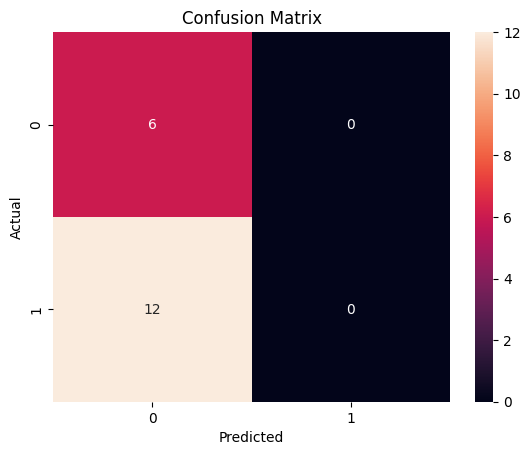

[I 2025-03-07 05:54:38,152] Trial 7 finished with value: 8.4022798538208 and parameters: {'learning_rate': 0.0001432414020932821, 'dropout_rate': 0.4797150544994321, 'batch_size': 32, 'weight_decay': 0.0004560986365223945, 'lstm_units': 32}. Best is trial 2 with value: 0.7450165152549744.
Epoch 1/10


<ipython-input-3-1d8b81e3c383>:134: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
<ipython-input-3-1d8b81e3c383>:135: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dr = trial.suggest_uniform("dropout_rate", 0.1, 0.5)
<ipython-input-3-1d8b81e3c383>:137: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  wd = trial.suggest_loguniform("weight_decay", 1e-5, 1e-3)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/

4/4 ━━━━━━━━━━━━━━━━━━━━ 51s 12s/step - accuracy: 0.3773 - loss: 5.1378 - val_accuracy: 0.3333 - val_loss: 3.1713
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 81s 12s/step - accuracy: 0.3773 - loss: 3.2689 - val_accuracy: 0.3333 - val_loss: 2.9321
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 81s 12s/step - accuracy: 0.3773 - loss: 2.7945 - val_accuracy: 0.3333 - val_loss: 2.7651
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 82s 12s/step - accuracy: 0.3773 - loss: 2.8854 - val_accuracy: 0.3333 - val_loss: 2.6421
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 85s 13s/step - accuracy: 0.3773 - loss: 2.5629 - val_accuracy: 0.3333 - val_loss: 2.5461
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 51s 13s/step - accuracy: 0.3773 - loss: 2.3679 - val_accuracy: 0.3333 - val_loss: 2.4711
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 81s 13s/step - accuracy: 0.3773 - loss: 2.2101 - val_accuracy: 0.3333 - val_loss: 2.4080
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 84s 13s/step - accuracy: 0.3773 - loss: 2.0783 - val_accuracy: 0.3333 - val_loss: 2.3552
Epoch 9/10


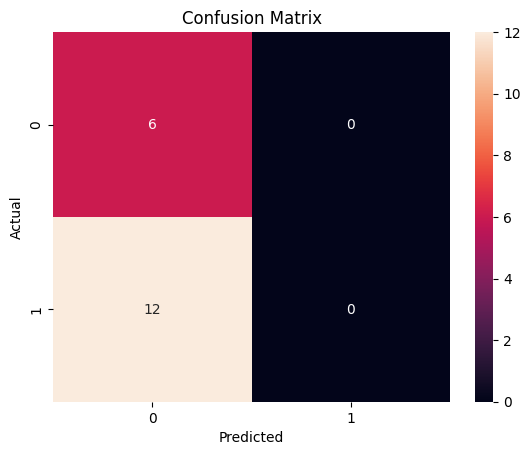

[I 2025-03-07 06:06:47,082] Trial 8 finished with value: 2.2738966941833496 and parameters: {'learning_rate': 5.945385774264234e-05, 'dropout_rate': 0.3652489047414974, 'batch_size': 16, 'weight_decay': 8.786786237613473e-05, 'lstm_units': 32}. Best is trial 2 with value: 0.7450165152549744.
Epoch 1/10


<ipython-input-3-1d8b81e3c383>:134: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
<ipython-input-3-1d8b81e3c383>:135: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dr = trial.suggest_uniform("dropout_rate", 0.1, 0.5)
<ipython-input-3-1d8b81e3c383>:137: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  wd = trial.suggest_loguniform("weight_decay", 1e-5, 1e-3)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/

2/2 ━━━━━━━━━━━━━━━━━━━━ 32s 16s/step - accuracy: 0.3441 - loss: 7.5523 - val_accuracy: 0.3333 - val_loss: 10.7471
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 28s 15s/step - accuracy: 0.3441 - loss: 6.0467 - val_accuracy: 0.3333 - val_loss: 8.3321
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 40s 15s/step - accuracy: 0.3441 - loss: 4.8332 - val_accuracy: 0.3333 - val_loss: 2.2029
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 40s 15s/step - accuracy: 0.3441 - loss: 1.5530 - val_accuracy: 0.3333 - val_loss: 1.7080
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 42s 15s/step - accuracy: 0.3441 - loss: 1.2736 - val_accuracy: 0.3333 - val_loss: 1.4585
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 41s 15s/step - accuracy: 0.3441 - loss: 1.0802 - val_accuracy: 0.3333 - val_loss: 1.2968
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 43s 17s/step - accuracy: 0.3441 - loss: 0.9870 - val_accuracy: 0.3333 - val_loss: 1.1798
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 40s 15s/step - accuracy: 0.3550 - loss: 0.9530 - val_accuracy: 0.3333 - val_loss: 1.0896
Epoch 9/10

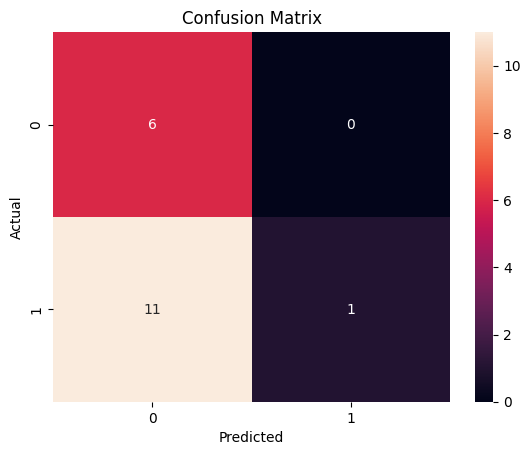

[I 2025-03-07 06:13:03,247] Trial 9 finished with value: 0.9528778791427612 and parameters: {'learning_rate': 0.0013221929997105485, 'dropout_rate': 0.21050602261222645, 'batch_size': 32, 'weight_decay': 0.00021871433928917933, 'lstm_units': 32}. Best is trial 2 with value: 0.7450165152549744.
Best hyperparameters:
{'learning_rate': 0.0015722873806834551, 'dropout_rate': 0.3937392288078445, 'batch_size': 64, 'weight_decay': 0.00047822792484812334, 'lstm_units': 64}
Best Test Accuracy: 0.8333333333333334


In [ ]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Masking, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
import optuna
import random
import tensorflow as tf


SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# ---------------------------
# Fixed Hyperparameters for Data Processing
# ---------------------------
epochs = 10  # Use the same number of epochs for each trial

# ---------------------------
# Data Preparation
# ---------------------------
input_dir = "issues-cleanedData"  # Directory with cleaned CSV files

# Lists to hold each repository's sequence and label
sequences = []
labels = []

# Determine union of all categories for the 'issue_state' column across all files
issue_state_categories = set()
for filename in os.listdir(input_dir):
    if filename.endswith(".csv"):
        file_path = os.path.join(input_dir, filename)
        try:
            df = pd.read_csv(file_path)
        except Exception as e:
            print(f"Error reading {filename}: {e}")
            continue
        if 'type' in df.columns:
            df = df[df['type'] != 'comment']
        if 'issue_state' in df.columns:
            unique_states = df['issue_state'].dropna().unique()
            issue_state_categories.update(unique_states)
issue_state_categories = sorted(list(issue_state_categories))

# Mapping for target labels: "graduated" is 1 and "retired" is 0
label_map = {"graduated": 1, "retired": 0}

# Process each CSV file (each representing one repository/sequence)
for filename in os.listdir(input_dir):
    if filename.endswith(".csv"):
        file_path = os.path.join(input_dir, filename)
        try:
            df = pd.read_csv(file_path)
        except Exception as e:
            print(f"Error reading {filename}: {e}")
            continue
        if 'type' in df.columns:
            df = df[df['type'] != 'comment']
        if not all(col in df.columns for col in ['issue_state', 'days_elapsed', 'status']):
            print(f"Skipping {filename}: required columns missing.")
            continue
        repo_status = df['status'].iloc[0]
        repo_status = repo_status.lower() if isinstance(repo_status, str) else repo_status
        if repo_status not in label_map:
            print(f"Skipping {filename}: status value '{repo_status}' not in label_map.")
            continue
        # One-hot encode 'issue_state'
        issue_state_dummies = pd.get_dummies(df['issue_state']).astype(int)
        issue_state_dummies = issue_state_dummies.reindex(columns=issue_state_categories, fill_value=0)
        # Normalize 'days_elapsed' using StandardScaler
        try:
            scaler = StandardScaler()
            days_elapsed_scaled = scaler.fit_transform(df[['days_elapsed']].astype(float))
            days_elapsed = pd.DataFrame(days_elapsed_scaled, columns=['days_elapsed'])
        except Exception as e:
            print(f"Error processing 'days_elapsed' in {filename}: {e}")
            continue
        # Combine features (only issue_state and days_elapsed)
        features = pd.concat([issue_state_dummies, days_elapsed], axis=1)
        features = features.fillna(0)
        seq = features.values
        if seq.shape[0] == 0:
            print(f"Skipping {filename}: no valid rows after filtering.")
            continue
        sequences.append(seq)
        labels.append(label_map[repo_status])

if not sequences:
    sys.exit("Error: No valid sequences found. Check CSV files for required columns and valid status values.")

# ---------------------------
# Sequence Padding
# ---------------------------
max_timesteps = max(seq.shape[0] for seq in sequences)
X = pad_sequences(sequences, maxlen=max_timesteps, dtype='float32', padding='post', value=-1.0)
y = np.array(labels)

print("Processed Data Summary:")
print("Number of sequences:", len(sequences))
print("Shape of padded sequences (X):", X.shape)
print("Labels (y):", y)

# Class Weights for Imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

# ---------------------------
# Train / Validation / Test Split (70/10/20)
# ---------------------------
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=42, shuffle=True
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=2/3, stratify=y_temp, random_state=42, shuffle=True
)

# ---------------------------
# Optuna Objective Function for Hyperparameter Tuning
# ---------------------------
def objective(trial):
    lr = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
    dr = trial.suggest_uniform("dropout_rate", 0.1, 0.5)
    bs = trial.suggest_categorical("batch_size", [16, 32, 64])
    wd = trial.suggest_loguniform("weight_decay", 1e-5, 1e-3)
    units = trial.suggest_categorical("lstm_units", [64, 32])

    model = Sequential()
    model.add(Masking(mask_value=-1.0, input_shape=(max_timesteps, X.shape[2])))
    model.add(LSTM(units, dropout=dr, kernel_regularizer=l2(wd)))
    model.add(Flatten())
    model.add(Dense(1, activation='relu', kernel_regularizer=l2(wd)))

    optimizer = Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    history = model.fit(X_train, y_train,
                        epochs=epochs,
                        batch_size=bs,
                        validation_data=(X_val, y_val),
                        class_weight=class_weight_dict,
                        verbose=1)

    y_pred_prob = model.predict(X_test)
    y_pred = (y_pred_prob > 0.5).astype(int).reshape(-1)
    acc = np.mean(y_pred == y_test)
    cm = confusion_matrix(y_test, y_pred)
    print(f"Test Accuracy: {acc}")
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # Store test accuracy in trial's user attributes
    trial.set_user_attr("test_acc", acc)

    return history.history['val_loss'][-1]

# ---------------------------
# Run Optuna Study with Status Bar
# ---------------------------
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=10, show_progress_bar=True)

print("Best hyperparameters:")
print(study.best_params)

# Corrected retrieval of best test accuracy
best_trial = study.best_trial
best_acc = best_trial.user_attrs.get("test_acc", None)

print(f"Best Test Accuracy: {best_acc}")
